In [1]:
import serial
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial.transform import Rotation as R

import math

def haversine(lat1, lon1, lat2, lon2):
      R = 6372.8 #km
      dLat = math.radians(lat2 - lat1)
      dLon = math.radians(lon2 - lon1)
      lat1 = math.radians(lat1)
      lat2 = math.radians(lat2)
      a = math.sin(dLat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dLon/2)**2
      c = 2*math.asin(math.sqrt(a))
      return R * c

def bearing(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    Bearing = math.atan2(math.sin(dlon)*math.cos(lat2), 
                         math.cos(lat1)*math.sin(lat2)-math.sin(lat1)*math.cos(lat2)*math.cos(dlon))

    return Bearing

gngga_cols = ['header',
        'utc time',
        'Lat',
        'Lat_Dir',
        'Lon',
        'Lon _Dir',
        'Quality_Indicator',
        'Satellites Used',
        'HDOP',
        'Altitude',
        'Alt_units',
        'Geoidal_Separation',
        'GS_units',
        'DGPS_Station_ID',
        'checksum']

gngga_types = [str, # header
         float, # utc time
         str, # lat
         str, # lat dir
         str, # lon
         str, # lon dir
         int, # quality indicator
         int, # N satellites
         float, # hdop
         float, # altitude
         str, # alt units
         float, #geoidal separation
         str, # gs units
         str, # dpgs station id
         str] # check sum

def extract_lon(l):
    l = str(l)
    # print("lon: ", l)
    return -float(l[:3]) - float(l[3:])/60.0 

def extract_lat(l):
    l = str(l)
    # print("lat: ", l)
    return float(l[:2]) + float(l[2:])/60.0 

In [5]:
gps_ser = serial.Serial()
gps_ser_open = False
attempts = 0

#attempt to connect
while not gps_ser_open and attempts < 5:
    try:
        gps_ser = serial.Serial('com11', 115200, timeout=None)
        gps_ser_open = True
    except:
        print("Failed to open pwm serial port: ", attempts)
        
    if not gps_ser_open:
        time.sleep(0.5)
        attempts += 1

gps_ser.flushInput()

start = time.time()
log_df = pd.DataFrame(columns=gngga_cols)

cnt = 0
max_time = 5.0
while time.time() - start < max_time:
    cnt += 1
    if gps_ser.in_waiting:
        gps_bytes = gps_ser.readline()
        # print("gps: ", gps_bytes)
        try:
            decoded_gps_strings = str(gps_bytes[0:len(gps_bytes)-2].decode("utf-8")).split(',')
            # print(decoded_gps_strings[0])
            if decoded_gps_strings[0] == '$GNGGA':
                # print(decoded_gps_strings)
                out = [ty(st) for st, ty in zip(decoded_gps_strings, gngga_types)]
                out[2] = extract_lat(out[2])
                out[4] = extract_lon(out[4])
                log_df.loc[len(log_df)] = out
                
        except:
            print("didn't work")
            continue

gps_ser.close()
print("Complete: ", cnt / max_time, " Hz")


Complete:  90953.6  Hz


In [3]:
m_lon = log_df["Lon"].mean()
m_lat = log_df["Lat"].mean()

log_df["dist2center"] = log_df.apply(lambda x: 1000.0 * haversine(x["Lat"], x["Lon"], m_lat, m_lon), axis=1)
log_df["bearing2center"] = log_df.apply(lambda x: bearing(m_lat, m_lon, x["Lat"], x["Lon"]), axis=1)
log_df["x"] = log_df.apply(lambda x: math.sin(x["bearing2center"]) * x["dist2center"], axis=1)
log_df["y"] = log_df.apply(lambda x: math.cos(x["bearing2center"]) * x["dist2center"], axis=1)

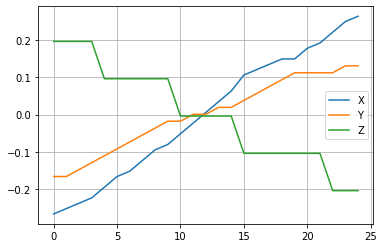

In [4]:
# display(log_df)

plt.plot(log_df.x, label='X')
plt.plot(log_df.y, label='Y')
plt.plot(log_df.Altitude - log_df["Altitude"].mean(), label='Z')
plt.grid()
plt.legend()
plt.show()